# Evaluation (CORA)

In [1]:
%load_ext autoreload
%load_ext memory_profiler
%autoreload 2

!mkdir ./cache
!mkdir ./cache/cora

mkdir: cannot create directory ‘./cache’: File exists
mkdir: cannot create directory ‘./cache/cora’: File exists


In [2]:
from impl.datasets.cora import CORA
from impl.pairs.doc2vec import D2VPairs
from impl.pairs.deepwalk import DWPairs
from impl.model.skipgram import SGNS
from impl.model.jce import JCE
from impl.utils.eval import eval_model, plot_evals
from gensim.models import Word2Vec, doc2vec
import numpy as np
import psutil

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Use importlib.util.find_spec() instead.
  """Entry point for launching an IPython kernel.


## Dataset

In [3]:
dataset = CORA(content_filename='./datasets/cora/cora.content', cites_filename='./datasets/cora/cora.cites')

print("Tagged docs: ", dataset.get_tagged_docs()[0:2])

Get tagged docs: 2708it [00:01, 2056.76it/s]

Tagged docs:  [TaggedDocument(words=['118', '125', '176', '252', '351', '456', '507', '521', '619', '648', '698', '702', '734', '845', '902', '1205', '1209', '1236', '1352', '1426'], tags=['31336']), TaggedDocument(words=['12', '509', '620', '763', '882', '893', '978', '1131', '1135', '1177', '1207', '1256', '1263', '1266', '1332', '1389', '1425'], tags=['1061127'])]


## Parameters

In [4]:
run_d2v = True
run_dw = True
run_jce = True
cache = True

params_d2v = {
   "pairs": {
       "neg_samples": 10,
       "sample": 0,
       "min_count": 5
   },
   "model": {
       "dim": 100,
       "alpha": 0.001,
       "iterations": 10,
       "batch_size": 4,
       "cache_file": "./cache/cora/d2v"
   }
}

params_dw = {
   "pairs": {
       "neg_samples": 10,
       "sample": 0.001,
       "min_count": 5,
       "walk_length": 40,
       "num_walks": 10,
       "window_size": 5
   },
   "model": {
       "dim": 100,
       "alpha": 0.001,
       "iterations": 10,
       "batch_size": 500,
       "cache_file": "./cache/cora/dw"
   }
}

params_jce_concat = {
    "dim": 200,
    "alpha": 0.001,
    "iterations": 10,
    "batch_sizes": [params_d2v["model"]["batch_size"],params_dw["model"]["batch_size"]],
    "cache_file": "./cache/cora/jce_concat"
}
params_jce_compare = {
    "dim": 100,
    "alpha": 0.001,
    "iterations": 10,
    "batch_sizes": [params_d2v["model"]["batch_size"],params_dw["model"]["batch_size"]],
    "cache_file": "./cache/cora/jce_compare"
}
params_jce_sine = {
    "dim": 100,
    "alpha": 0.001,
    "iterations": 10,
    "batch_sizes": [params_d2v["model"]["batch_size"],params_dw["model"]["batch_size"]],
    "cache_file": "./cache/cora/jce_sine"
}

## Input Pairs

In [5]:
d2vpairs = D2VPairs(dataset=dataset, **params_d2v["pairs"])
dwpairs = DWPairs(dataset=dataset, **params_dw["pairs"])

DeepWalk: Generate walks:   0%|          | 0/10 [00:00<?, ?it/s]

Removed 0 unknown nodes


DeepWalk: Generate walks: 100%|██████████| 10/10 [00:22<00:00,  2.24s/it]


## Doc2Vec

Using GPU
Loading cached embeddings...


Evaluating model:   0%|          | 0/10 [00:00<?, ?it/s]

Eval D2V:  [(0.7043709031194532, 0.009866591610035017), (0.7351550960118168, 0.00813883445433141)]


Evaluating model: 100%|██████████| 10/10 [00:40<00:00,  4.06s/it]


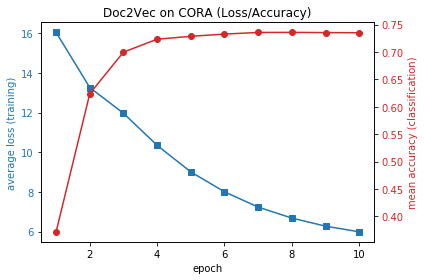

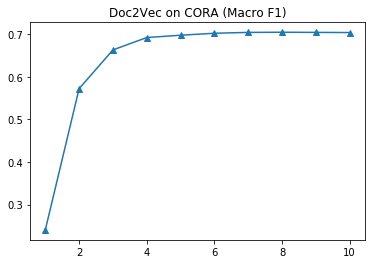

In [6]:
if run_d2v:
    d2vmodel = SGNS(d2vpairs, cache=cache, **params_d2v["model"])
    d2vemb = d2vmodel.embeddings[str(params_d2v["model"]["iterations"])]

    print("Eval D2V: ", eval_model(d2vemb, dataset=dataset))
    # gensim_d2v = doc2vec.Doc2Vec(dataset.get_tagged_docs(), negative=params_d2v["pairs"]["neg_samples"], sample=params_d2v["pairs"]["sample"], min_count=params_d2v["pairs"]["min_count"], vector_size=params_d2v["model"]["dim"], epochs=params_d2v["model"]["iterations"], dm=1, hs=0, alpha=params_d2v["model"]["alpha"])
    # print("Eval Gensim D2V: ", eval_model(gensim_d2v.docvecs, dataset=dataset))
    
    plot_evals(d2vmodel, title="Doc2Vec on CORA", dataset=dataset)

## DeepWalk

Using GPU
Loading cached embeddings...


Evaluating model:   0%|          | 0/10 [00:00<?, ?it/s]

Eval DW:  [(0.7991811993293645, 0.01114129833757324), (0.8081979320531758, 0.009141656361093957)]


Evaluating model: 100%|██████████| 10/10 [00:55<00:00,  5.58s/it]


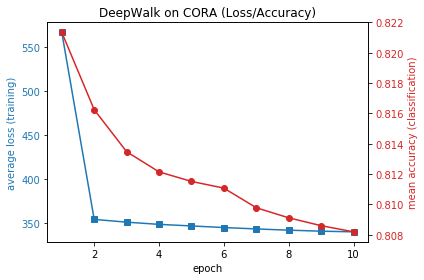

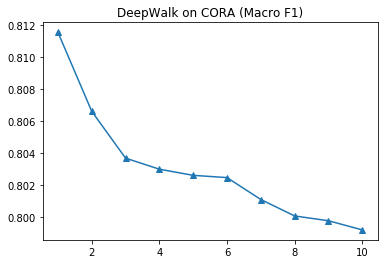

In [7]:
if run_dw:
    dwmodel = SGNS(dwpairs, cache=cache, **params_dw["model"])
    dwemb = dwmodel.embeddings[str(params_dw["model"]["iterations"])]

    print("Eval DW: ", eval_model(dwemb, dataset=dataset))
    # gensim_w2v = Word2Vec(dwpairs.sentences, negative=params_dw["pairs"]["neg_samples"], sample=params_dw["pairs"]["sample"], min_count=params_dw["pairs"]["min_count"], size=params_dw["model"]["dim"], iter=params_dw["model"]["iterations"], window=params_dw["pairs"]["window_size"], sg=1, alpha=params_dw["model"]["alpha"], hs=0, compute_loss=True)
    # print("Eval Gensim DW: ", eval_model(gensim_w2v.wv, dataset=dataset))
    
    plot_evals(dwmodel, title="DeepWalk on CORA", dataset=dataset)

## DW+D2V

Evaluating model:   0%|          | 0/10 [00:00<?, ?it/s]

Eval D2VDW:  [(0.826327199109022, 0.01115158922590644), (0.8378138847858198, 0.010282602235720603)]


Evaluating model: 100%|██████████| 10/10 [01:24<00:00,  8.50s/it]


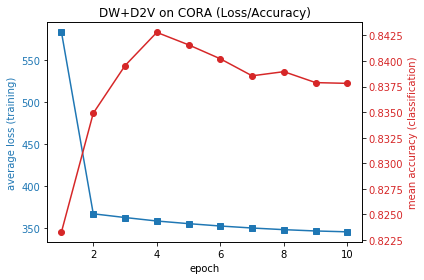

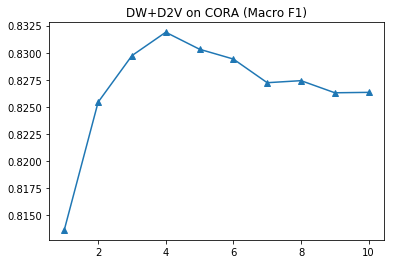

In [8]:
if run_d2v and run_dw:
    class D2VDWModel:
        def __init__(self):
            self.embeddings = dict()
            self.losses = dict()
    
    d2vdwmodel = D2VDWModel()
    
    for epoch in d2vmodel.embeddings.keys():
        d2v_emb_epoch = d2vmodel.embeddings[epoch]
        dw_emb_epoch = dwmodel.embeddings[epoch]
        d2v_loss_epoch = d2vmodel.losses[epoch]
        dw_loss_epoch = dwmodel.losses[epoch]
        
        d2vdwmodel.embeddings[epoch] = dict()
        for k in d2v_emb_epoch.keys():
            a = d2v_emb_epoch[k]
            b = dw_emb_epoch[k]
            d2vdwmodel.embeddings[epoch][k] = np.concatenate((a, b))
        d2vdwmodel.losses[epoch] = d2v_loss_epoch + dw_loss_epoch
    
    print("Eval D2VDW: ", eval_model(d2vdwmodel.embeddings['10'], dataset=dataset))
    plot_evals(d2vdwmodel, title="DW+D2V on CORA", dataset=dataset)

## JCE-CNC

Using GPU
Loading cached embeddings...


Evaluating model:   0%|          | 0/10 [00:00<?, ?it/s]

Eval JCE (Concat):  [(0.8204690323573163, 0.008230839525642873), (0.8322008862629247, 0.007949651636072185)]


Evaluating model: 100%|██████████| 10/10 [01:26<00:00,  8.61s/it]


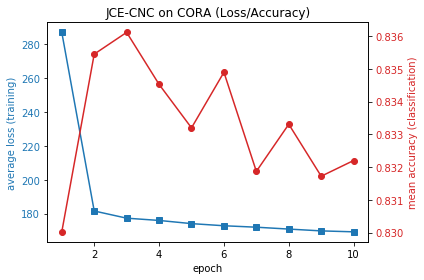

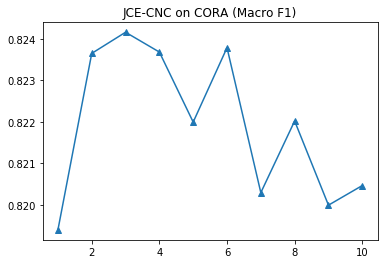

In [9]:
if run_jce:
    jceemb_concat = JCE(data=[d2vpairs, dwpairs], cache=cache, **params_jce_concat)

    print("Eval JCE (Concat): ", eval_model(jceemb_concat.embeddings[str(params_jce_concat["iterations"])], dataset=dataset))
    plot_evals(jceemb_concat, title="JCE-CNC on CORA", dataset=dataset)

## JCE-CMP

Using GPU
Loading cached embeddings...


Evaluating model:   0%|          | 0/10 [00:00<?, ?it/s]

Eval JCE (Compare):  [(0.7990219384290569, 0.009457309561603566), (0.8133677991137371, 0.00873273845998225)]


Evaluating model: 100%|██████████| 10/10 [01:00<00:00,  6.10s/it]


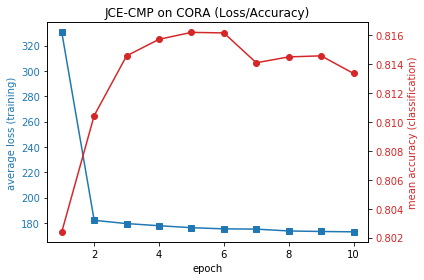

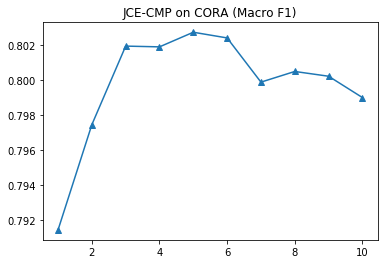

In [10]:
if run_jce:
    jceemb_compare = JCE(data=[d2vpairs, dwpairs], cache=cache, **params_jce_compare)

    print("Eval JCE (Compare): ", eval_model(jceemb_compare.embeddings[str(params_jce_compare["iterations"])], dataset=dataset))
    plot_evals(jceemb_compare, title="JCE-CMP on CORA", dataset=dataset)

## JCE-D2V/JCE-DW

Evaluating model:   0%|          | 0/10 [00:00<?, ?it/s]

Eval JCE-D2V:  [(0.3154359955006917, 0.010005103185854439), (0.37699409158050223, 0.008242308068776499)]


Evaluating model: 100%|██████████| 10/10 [00:45<00:00,  4.58s/it]


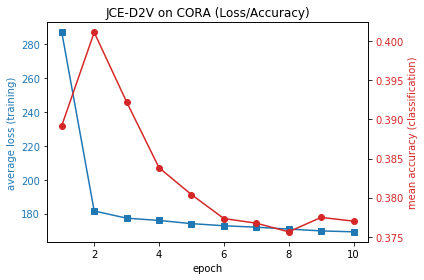

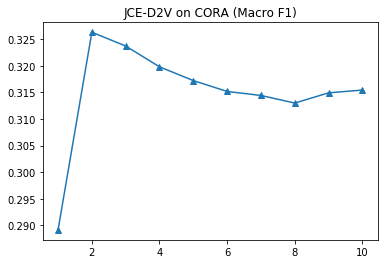

Evaluating model:   0%|          | 0/10 [00:00<?, ?it/s]

Eval JCE-DW:  [(0.7932755205299005, 0.010461305428590053), (0.8033604135893648, 0.008862244575600722)]


Evaluating model: 100%|██████████| 10/10 [00:58<00:00,  5.88s/it]


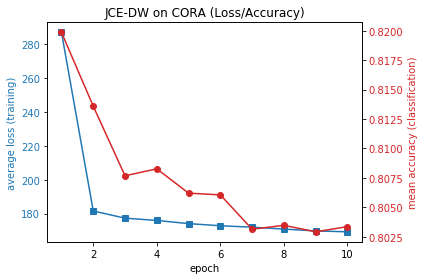

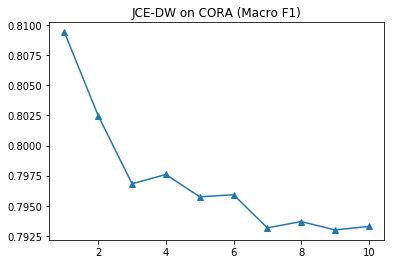

In [11]:
if run_jce:
    class JCESplitModel:
        def __init__(self):
            self.embeddings = dict()
            self.losses = dict()
    
    d2vjcemodel = JCESplitModel()
    dwjcemodel = JCESplitModel()
    
    for epoch in jceemb_concat.embeddings.keys():
        jceemb_epoch = jceemb_concat.embeddings[epoch]
        jceloss_epoch = jceemb_concat.losses[epoch]
                
        d2vjcemodel.embeddings[epoch] = dict()
        dwjcemodel.embeddings[epoch] = dict()
        for k in jceemb_epoch.keys():
            a = jceemb_epoch[k]
            half = len(a)//2
            d2vjcemodel.embeddings[epoch][k] = a[:half]
            dwjcemodel.embeddings[epoch][k] = a[half:]
        d2vjcemodel.losses[epoch] = jceloss_epoch
        dwjcemodel.losses[epoch] = jceloss_epoch
    
    print("Eval JCE-D2V: ", eval_model(d2vjcemodel.embeddings['10'], dataset=dataset))
    plot_evals(d2vjcemodel, title="JCE-D2V on CORA", dataset=dataset)
    
    print("Eval JCE-DW: ", eval_model(dwjcemodel.embeddings['10'], dataset=dataset))
    plot_evals(dwjcemodel, title="JCE-DW on CORA", dataset=dataset)

## SINE(Reprod.)

Using GPU
Loading cached embeddings...


Evaluating model:   0%|          | 0/10 [00:00<?, ?it/s]

Eval JCE (SINE):  [(0.834513862936198, 0.011089155812515435), (0.8451994091580503, 0.009258160597832875)]


Evaluating model: 100%|██████████| 10/10 [01:01<00:00,  6.17s/it]


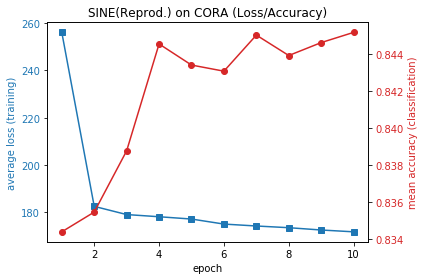

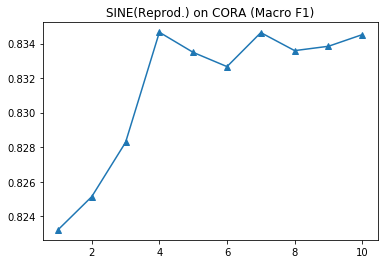

In [12]:
if run_jce:
    jceemb_sine = JCE(data=[d2vpairs, dwpairs], cache=cache, disable_grad=False, **params_jce_sine)

    print("Eval JCE (SINE): ", eval_model(jceemb_sine.embeddings[str(params_jce_sine["iterations"])], dataset=dataset))
    plot_evals(jceemb_sine, title="SINE(Reprod.) on CORA", dataset=dataset)